# Shared graphs between models
For comparative plots

In [126]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
%matplotlib inline
style.use('seaborn-v0_8-ticks')

In [127]:
def determine_unit(target):
    """Determine the unit based on the target variable."""
    return 'MASL' if 'GV' in target else 'L/s' if 'MB' in target else None

def load_model_data(models, target):
    """
    Load model data efficiently.
    
    Args:
        models (list): List of model names
        target (str): Target variable name
    
    Returns:
        tuple: Tuple containing plotting data, predictions, dates, split index, and actual y values
    """
    plotting_data = {}
    
    # Validate models input
    if not models:
        raise ValueError("Models list cannot be empty")
    
    # Load data for each model
    for model in models:
        try:
            with open(f'plotting_data/{model}/{model}_{target}_plotting_data.pkl', 'rb') as f:
                model_data = pickle.load(f)
                plotting_data[model] = model_data
        except FileNotFoundError:
            print(f"Warning: Data file for model {model} not found. Skipping.")
            continue
    
    # Validate data loading
    if not plotting_data:
        raise ValueError(f"No plotting data could be loaded for target {target}")
    
    # Use the first successfully loaded model as reference
    reference_model = list(plotting_data.keys())[0]
    
    # Extract common data
    dates = plotting_data[reference_model]['dates']
    split_index = plotting_data[reference_model]['split_index']
    actual_y = plotting_data[reference_model]['actual_y']
    
    # Create predictions dictionary, handling potential missing predictions
    predictions_dict = {}
    for model in plotting_data:
        predictions = plotting_data[model].get('predictions')
        if predictions is not None:
            predictions_dict[model] = predictions
    
    return plotting_data, predictions_dict, dates, split_index, actual_y

def plot_models(target, models, model_colors, model_markers, predictions_dict, dates, split_index, actual_y, shared_residual_axis):
    """
    Create comprehensive model performance visualization.
    
    Args:
        target (str): Target variable name
        models (list): List of model names
        model_colors (dict): Color mapping for models
        model_markers (dict): Marker mapping for models
        predictions_dict (dict): Dictionary of model predictions
        dates (pd.Series): Date series
        split_index (int): Index for train-test split
        actual_y (pd.Series): Actual target values
        shared_residual_axis (bool): Determines if residual plots should use same range
    """
    # Determine unit
    unit = determine_unit(target)
    
    # Filter models to only those with predictions
    valid_models = list(predictions_dict.keys())
    
    # Create subplot with 8 rows and 1 column
    fig, axes = plt.subplots(
        2 * len(valid_models), 1, 
        figsize=(14, 6 * len(valid_models)), 
        sharex=True,
        gridspec_kw={'height_ratios': [3, 1] * len(valid_models)}
    )
    
    # Ensure axes is always a list, even if only one model
    if len(valid_models) == 1:
        axes = [axes[0], axes[1]]

    if shared_residual_axis:
        # Calculate global residual limits
        all_residuals = []
        for model in valid_models:
            predictions = predictions_dict[model]
            residuals = actual_y - predictions
            all_residuals.extend(residuals)
        
        # Determine symmetrical y-limits for residuals
        max_abs_residual = max(abs(np.min(all_residuals)), abs(np.max(all_residuals)))
        residual_ylim = (-max_abs_residual, max_abs_residual)
    
    # Plot for each model
    for i, model in enumerate(valid_models):
        predictions = predictions_dict[model]
        
        # Subplot for predictions
        ax1 = axes[2 * i]
        ax1.scatter(dates, actual_y, color='black', s=0.6, label='Obs.')
        ax1.scatter(dates, predictions, 
                    color=model_colors.get(model, 'gray'), 
                    s=1, alpha=0.9, 
                    label=model, 
                    marker=model_markers.get(model, 'o'))
        ax1.axvline(x=dates.iloc[split_index], color='gray', alpha=0.5, linestyle='--')
        
        # Formatting for predictions subplot
        ax1.tick_params(axis='y', labelsize=12)
        ax1.set_ylabel(f'{target} ({unit})', color='black', fontsize=16, labelpad=7)
        ax1.legend(loc='upper left', fontsize=14, ncols=2, 
                   markerscale=8, columnspacing=0.6, 
                   handlelength=1.3, handletextpad=0.3, borderpad=0.2)
        ax1.grid()
        
        # Subplot for residuals
        ax2 = axes[2 * i + 1]
        residuals = actual_y - predictions
        ax2.scatter(dates, np.array(residuals), 
                    color=model_colors.get(model, 'gray'), 
                    s=1, alpha=0.6, 
                    marker=model_markers.get(model, 'o'))
        ax2.axhline(y=0, color='gray', linewidth=0.6, linestyle='-')
        ax2.set_ylabel(rf'$\epsilon$ ({unit})', color='black', fontsize=16, labelpad=1.5)

        if shared_residual_axis:
            # Set consistent y-limits for residuals
            ax2.set_ylim(residual_ylim)
        
        # Configure x-axis for residuals subplot
        ax2.tick_params(axis='x', which='both', bottom=True, top=False, 
                        labelbottom=True, labelsize=12)
        ax2.tick_params(axis='y', labelsize=12)
    
    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(right=0.59)
    
    # Additional scatter plots for each model
    for i, model in enumerate(valid_models):
        # Calculate position for scatter plot
        y_position = 0.7625 - 0.2485 * i
        
        # Create axes for scatter plot
        ax = fig.add_axes([0.65, y_position, 0.2, 0.10])
        fig.text(0.4072, y_position+0.0645, 'TEST', color='black', fontsize=12)
        
        # Get predictions for this model
        predictions = predictions_dict[model]
        
        # Determine min and max values
        min_val = min(actual_y.min(), predictions.min()) + 0.1
        max_val = max(actual_y.max(), predictions.max()) - 0.1
        
        # Plot diagonal line
        ax.plot([min_val, max_val], [min_val, max_val], 
                color='grey', linestyle='--', linewidth=1)
        
        # Scatter plot of actual vs predicted
        ax.scatter(actual_y, predictions, 
                   color=model_colors.get(model, 'gray'),
                   alpha=0.9, s=1, 
                   marker=model_markers.get(model, 'o'))
        
        # Set labels
        ax.set_xlabel(f'Measurements ({unit})', fontsize=13)
        ax.set_ylabel(f'Predicted values ({unit})', fontsize=13)
    
    plt.show()

def main_plot(target, shared_residual_axis):
    """
    Main function to plot model performance.
    
    Args:
        target (str): Target variable name
        shared_residual_axis (bool): Determines if residual plots should use same range
    """
    # Define models
    models = ['HST', 'GBRT', 'XGBoost', 'LightGBM']
    
    # Model colors and markers
    model_colors = {
        'HST': '#1E90FF',       # Dodger Blue
        'GBRT': '#FF6347',      # Tomato Red
        'XGBoost': '#2E8B57',   # Sea Green
        'LightGBM': '#9932CC'   # Dark Orchid
    }
    
    model_markers = {
        'HST': '+',         # Plus
        'GBRT': '^',        # Triangle up
        'XGBoost': 'x',     # cross
        'LightGBM': 'D'     # Diamond
    }
    
    # Load model data
    plotting_data, predictions_dict, dates, split_index, actual_y = load_model_data(models, target)
    
    # Extract metrics
    metrics_dict = {
        'RMSE': {model: plotting_data[model]['RMSE'] for model in predictions_dict},
        'MAE': {model: plotting_data[model]['MAE'] for model in predictions_dict},
        'NSE': {model: plotting_data[model]['NSE'] for model in predictions_dict},
        'KGE': {model: plotting_data[model]['KGE'] for model in predictions_dict}
    }
    
    # Plot models
    plot_models(
        target, 
        list(predictions_dict.keys()), 
        model_colors, 
        model_markers, 
        predictions_dict, 
        dates, 
        split_index, 
        actual_y,
        shared_residual_axis
    )

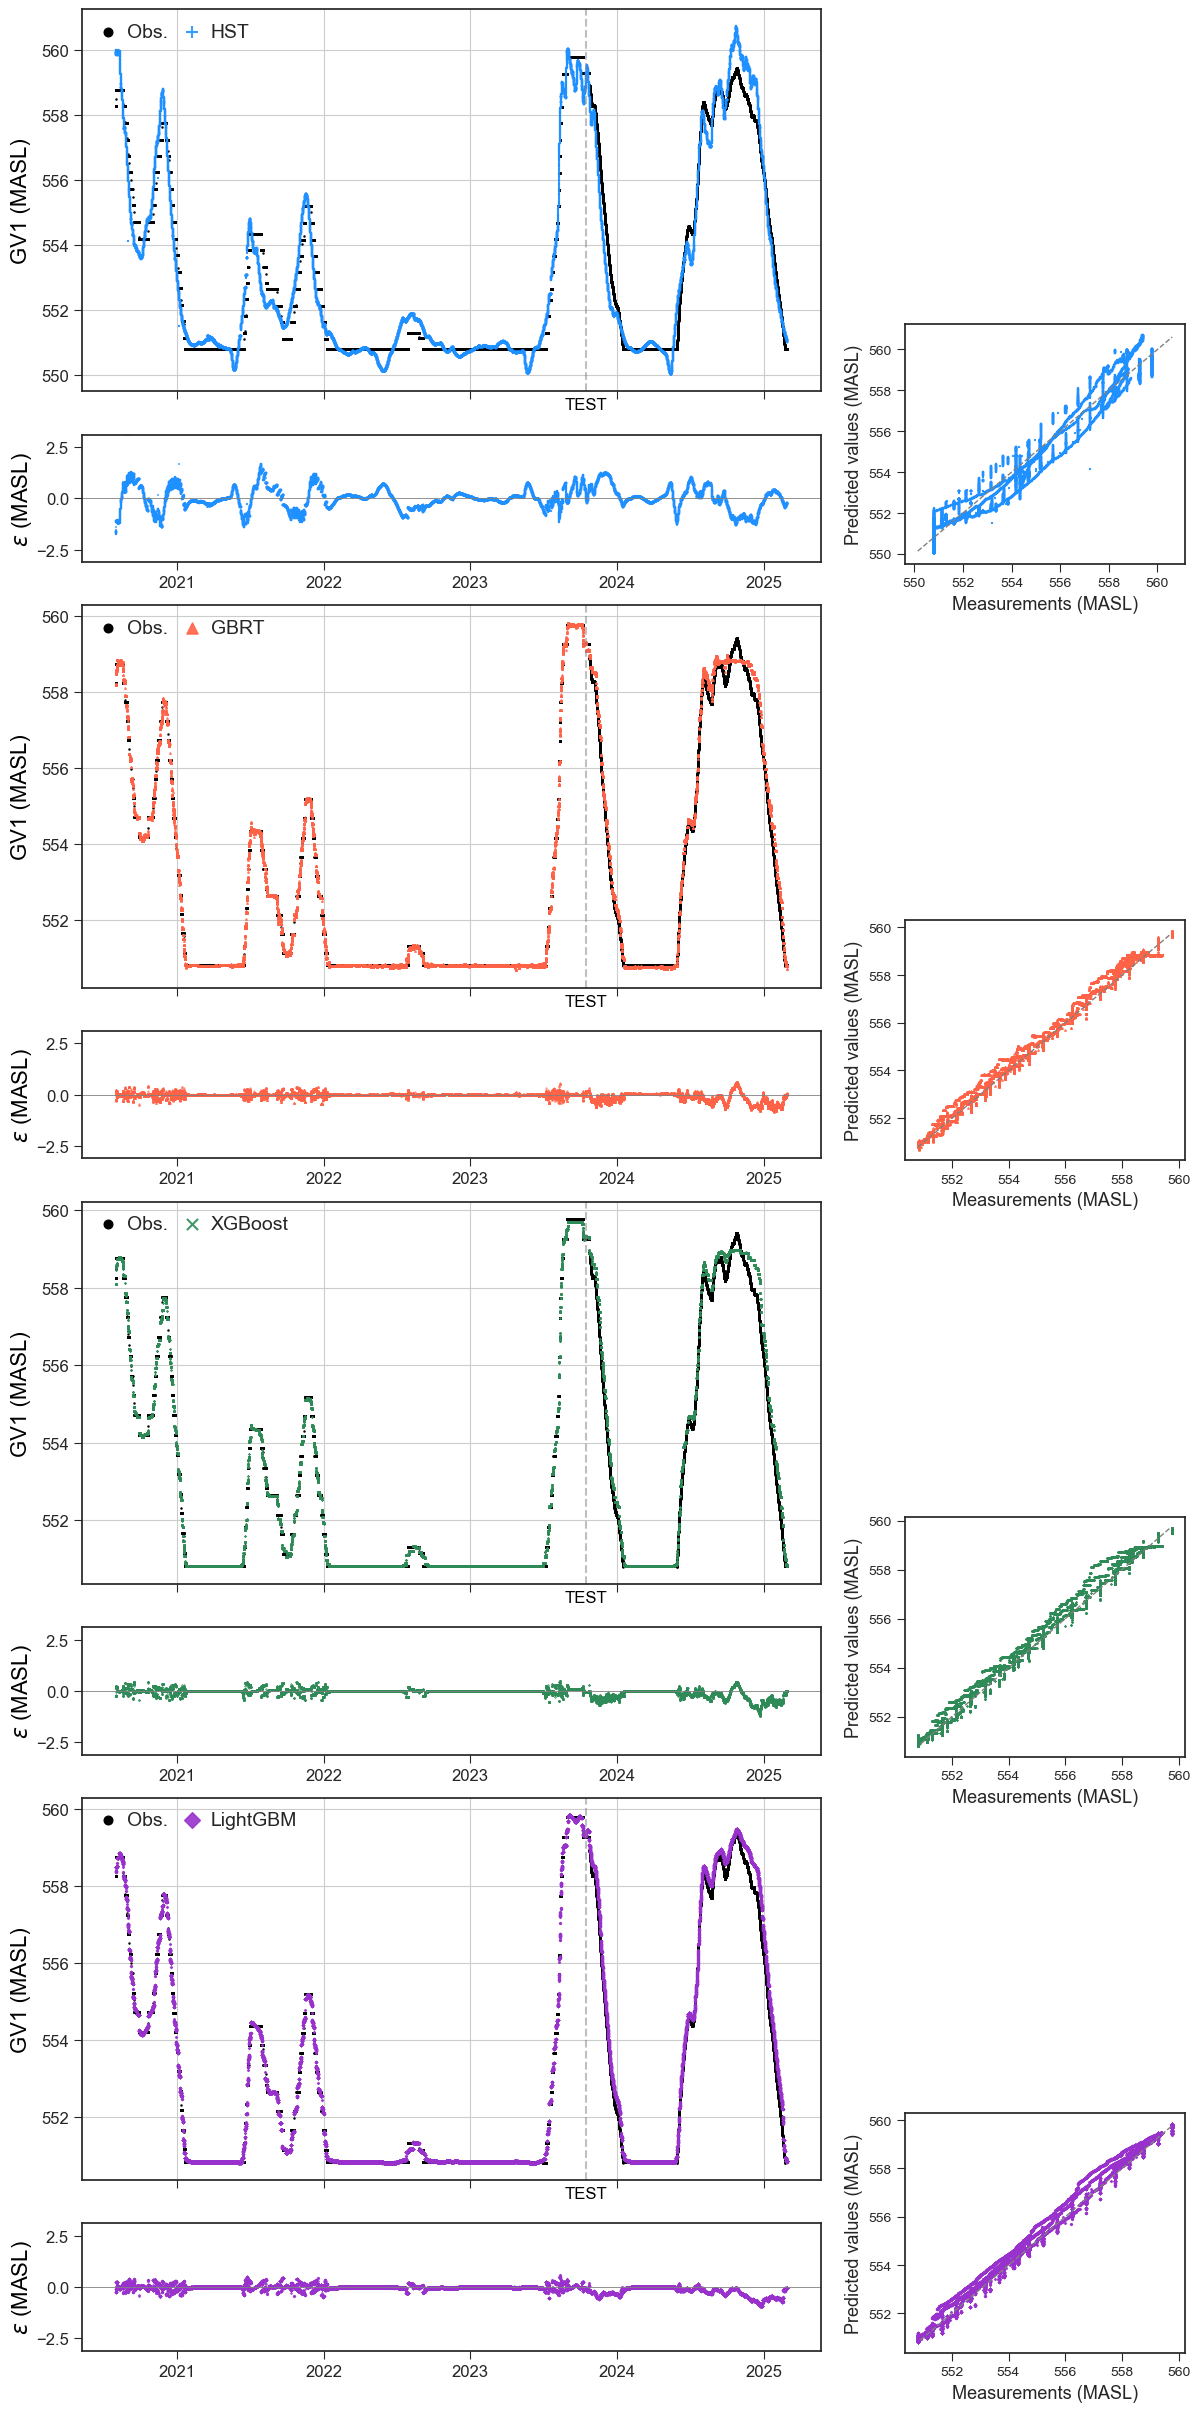

In [128]:
# Example usage
main_plot('GV1', shared_residual_axis=True)

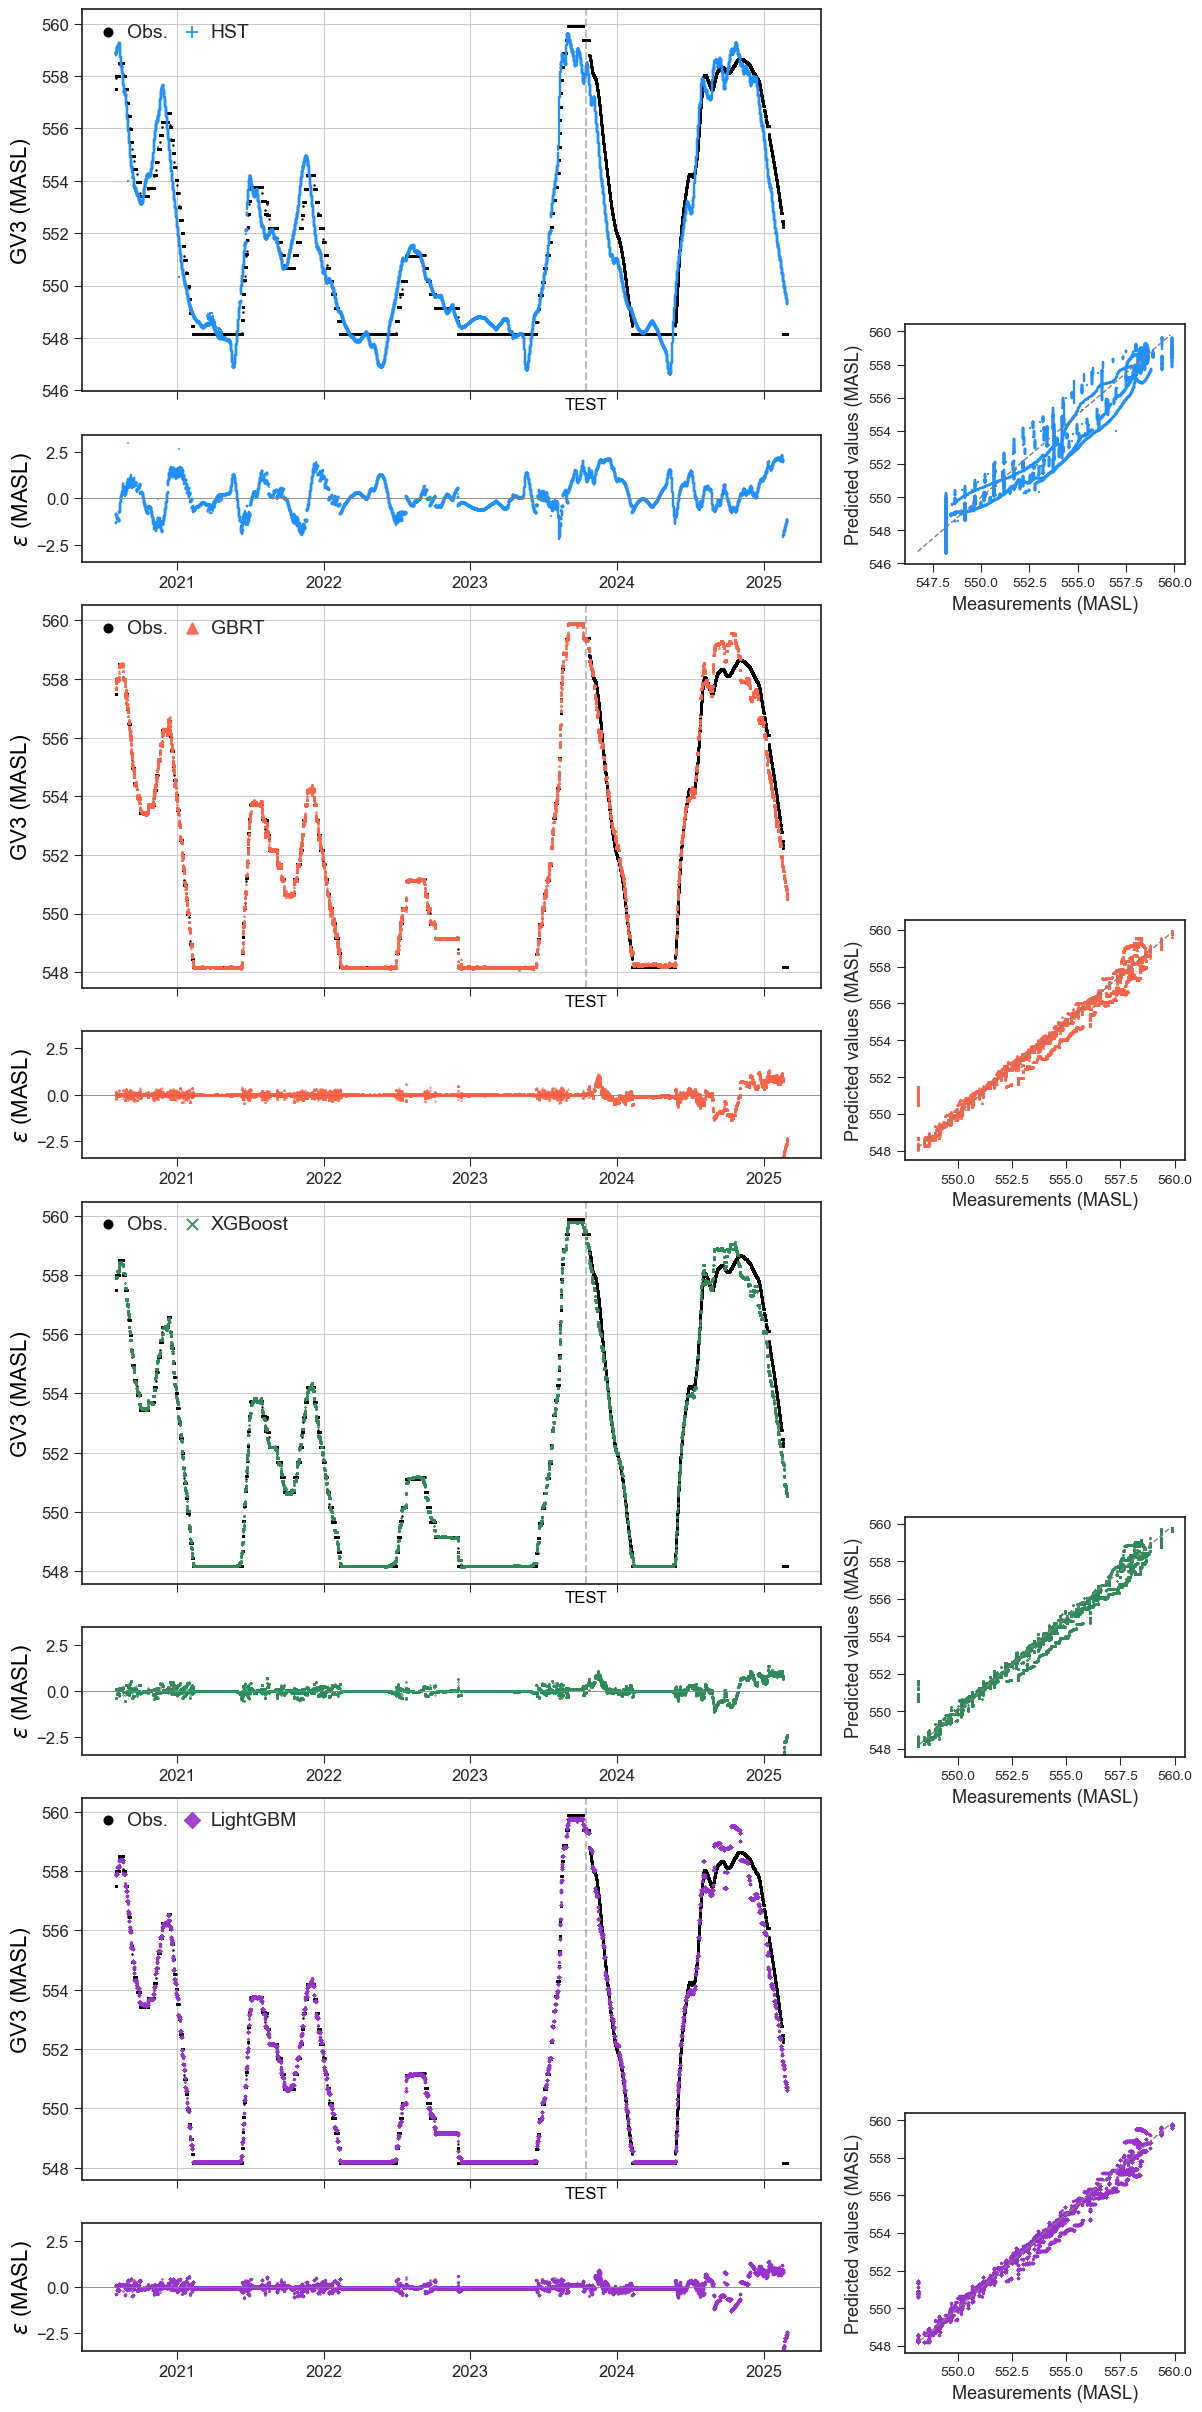

In [129]:
main_plot('GV3', shared_residual_axis=True)

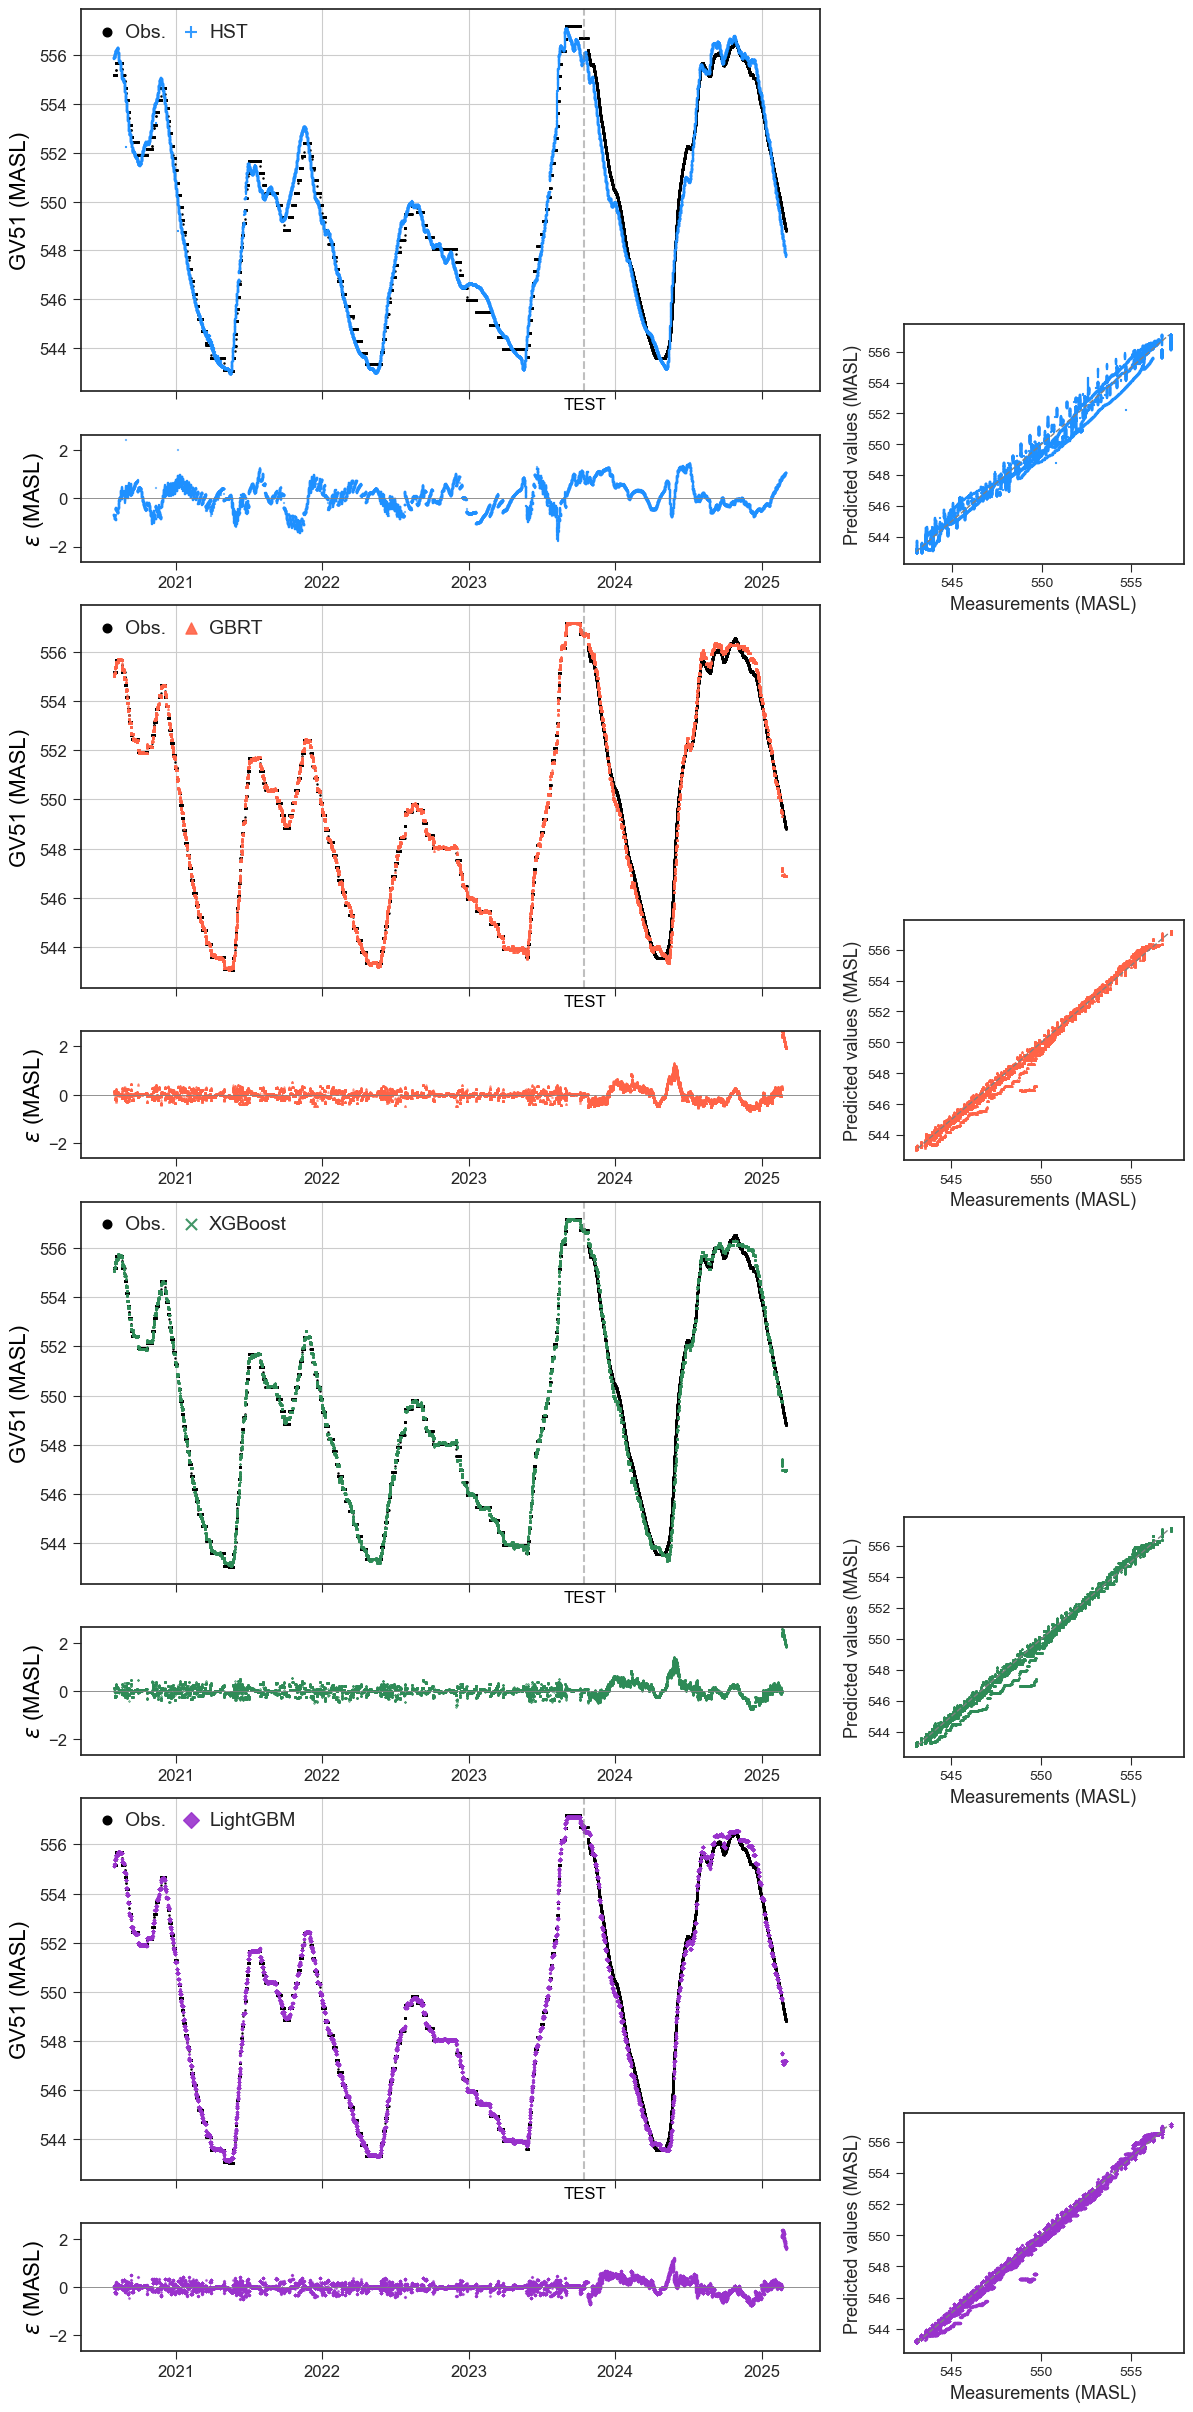

In [130]:
main_plot('GV51', shared_residual_axis=True)

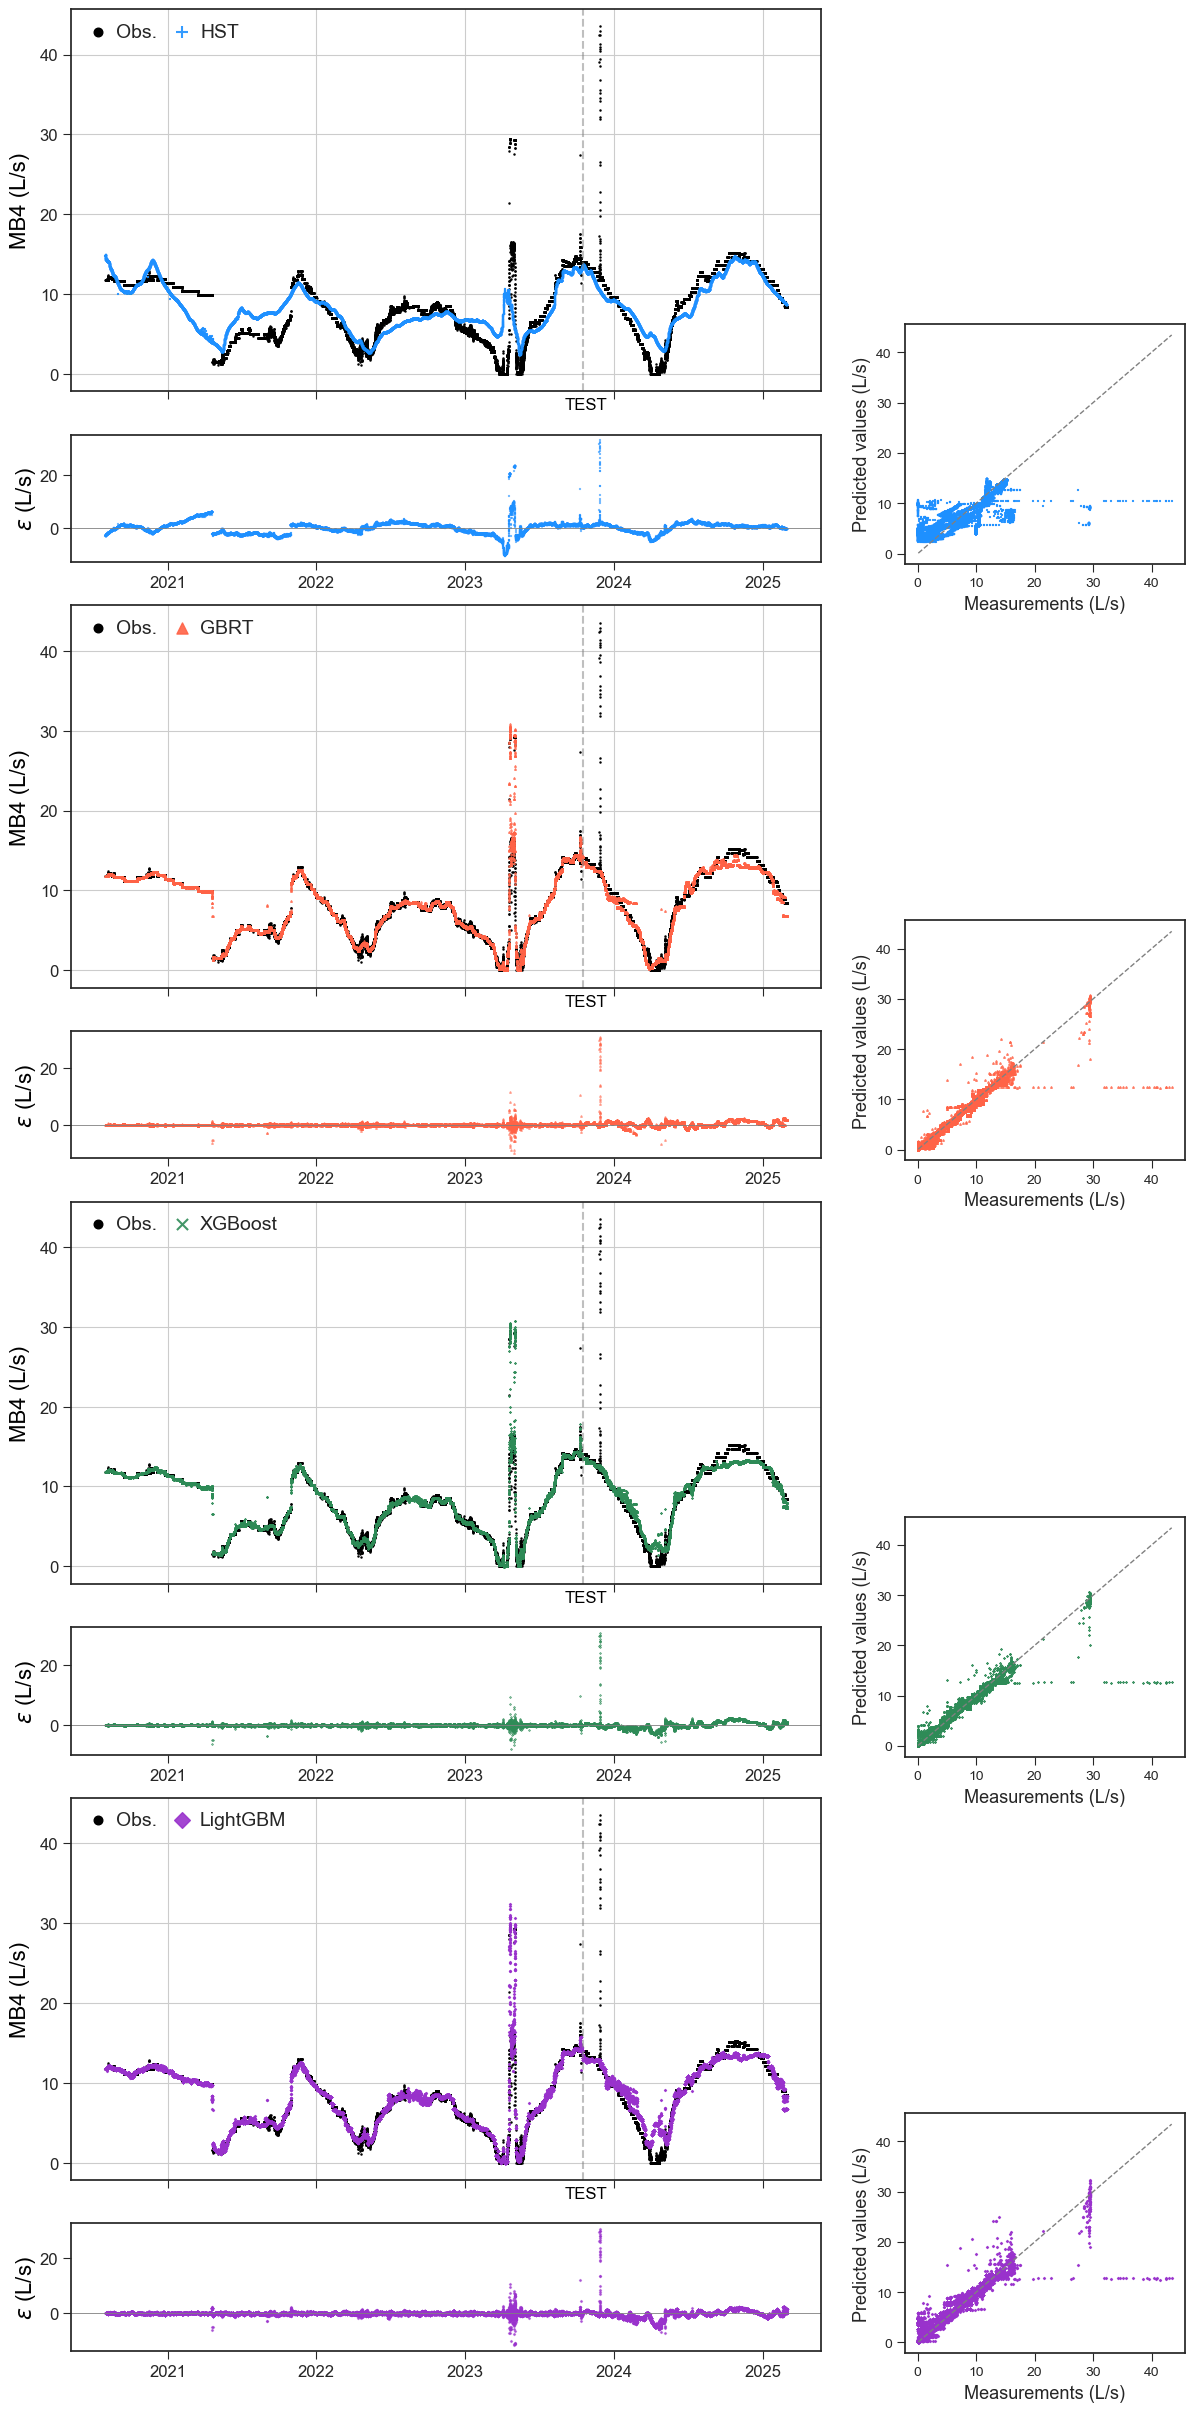

In [131]:
main_plot('MB4', shared_residual_axis=False)

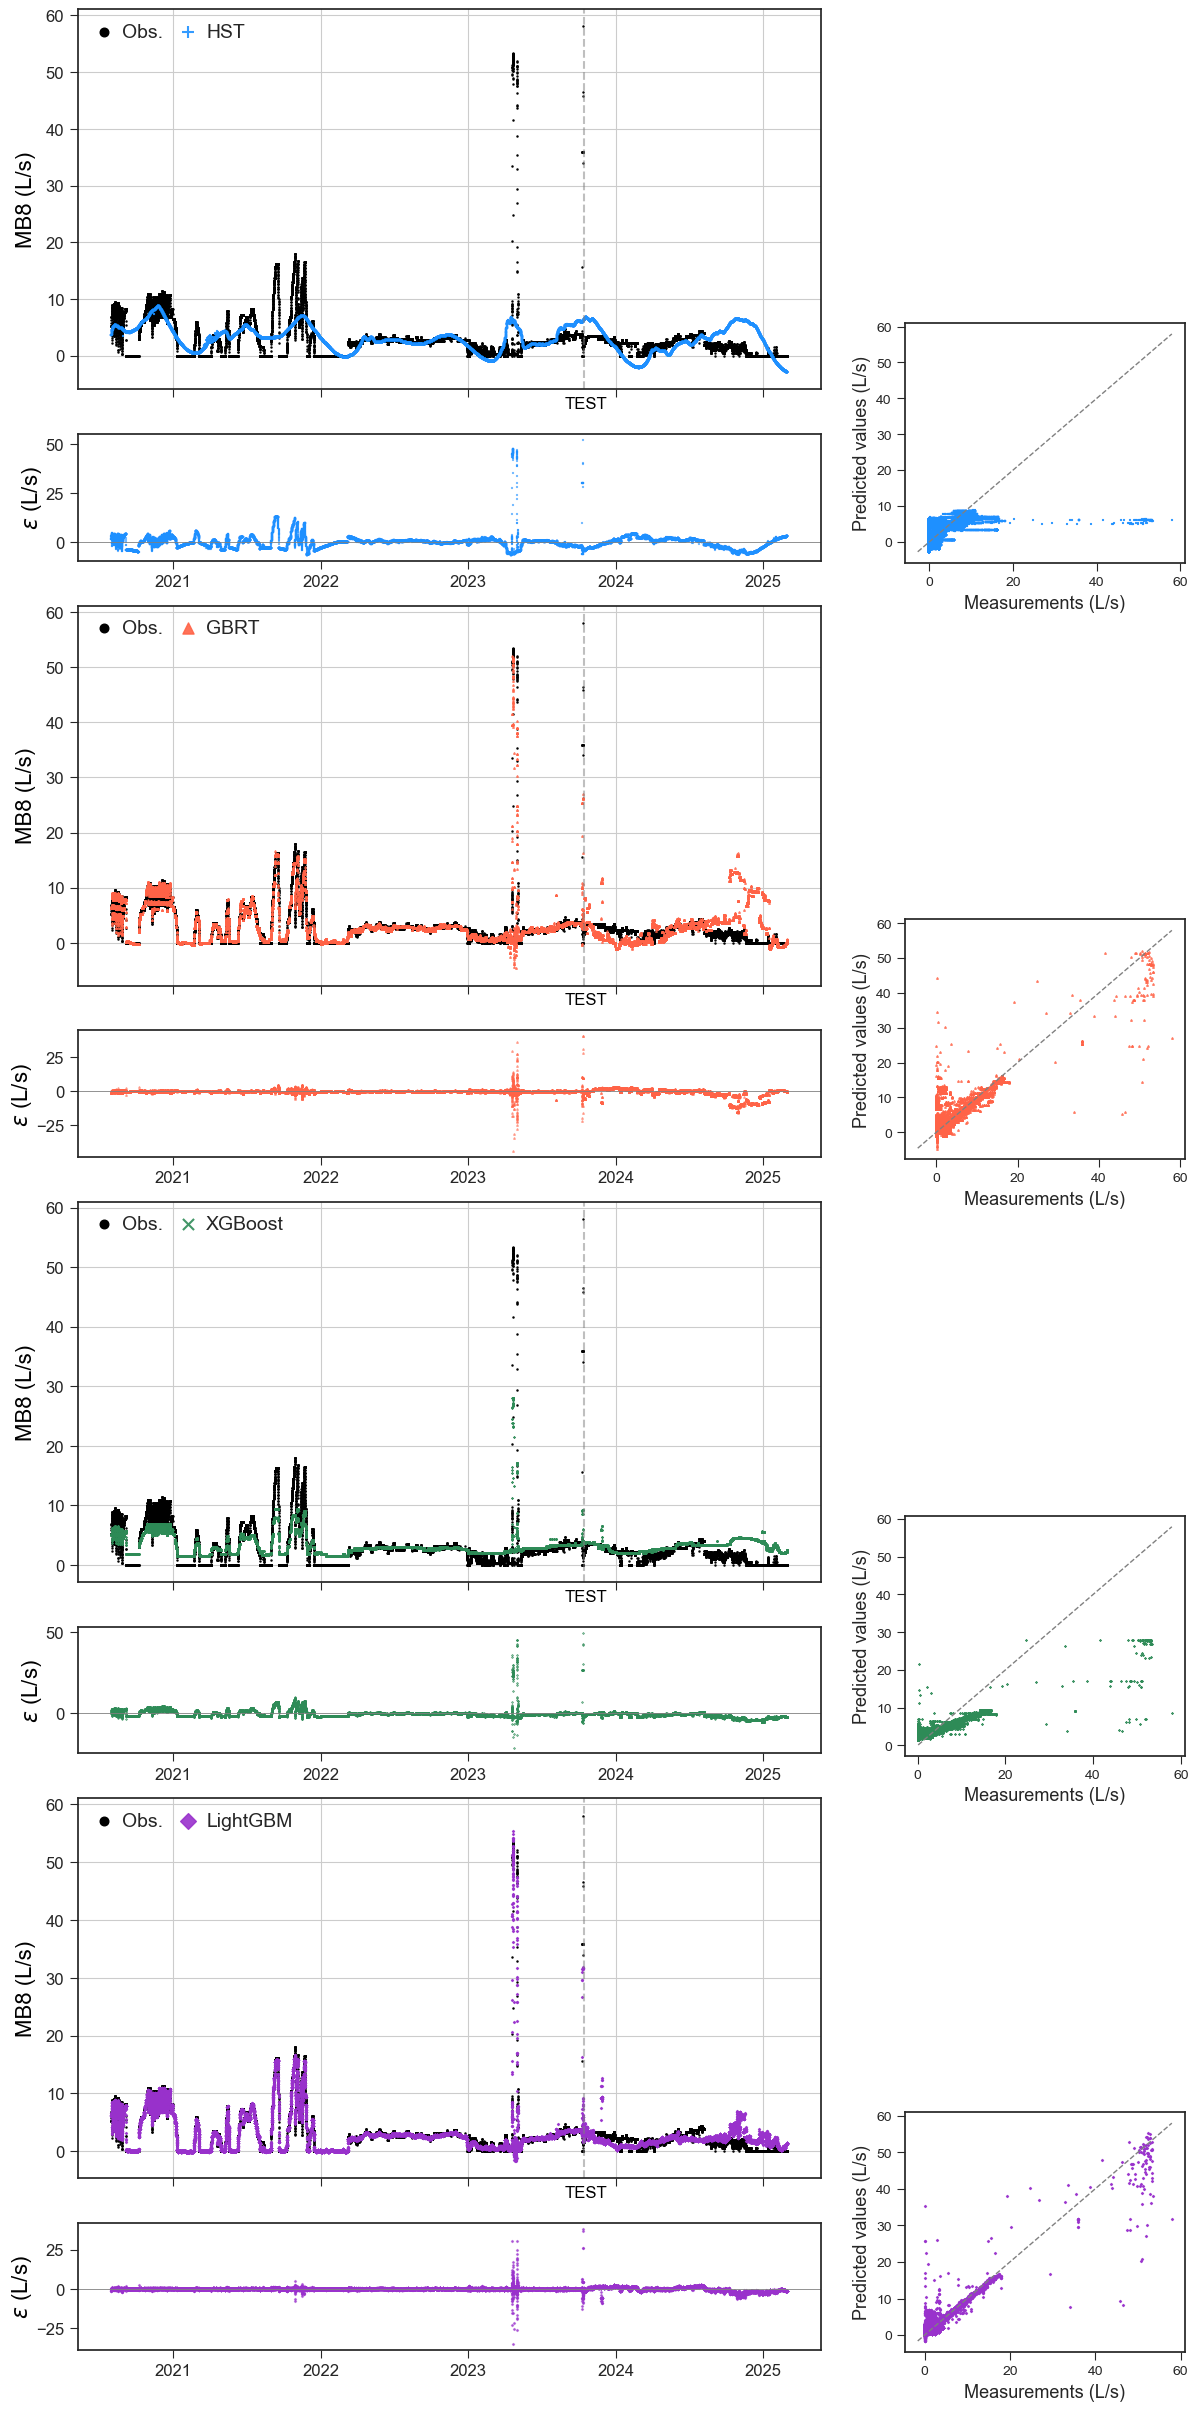

In [132]:
main_plot('MB8', shared_residual_axis=False)

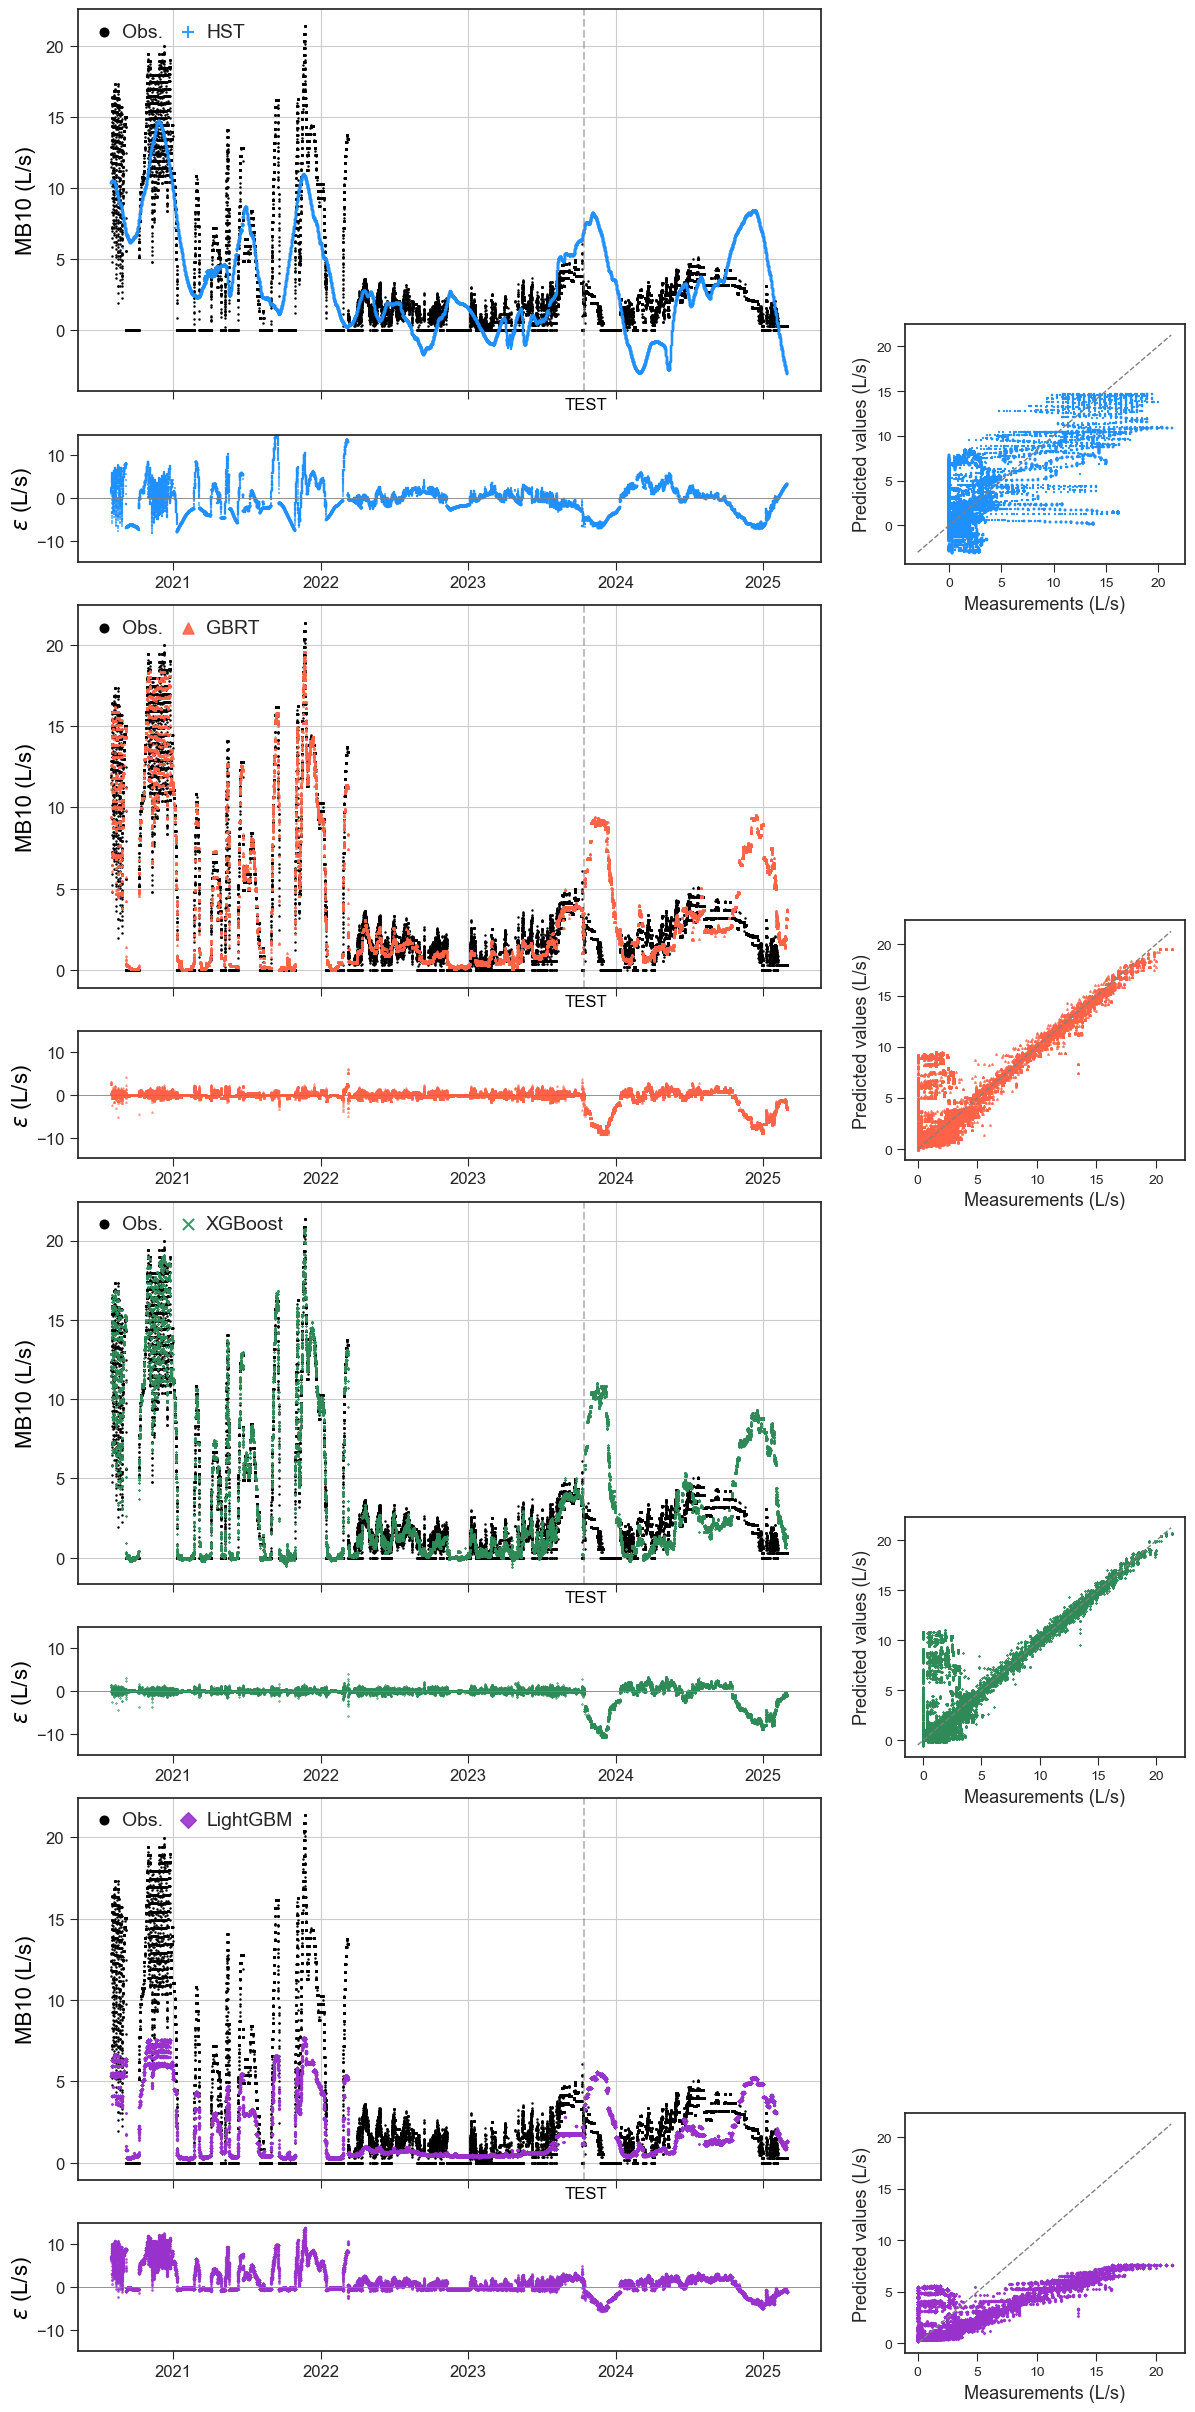

In [133]:
main_plot('MB10', shared_residual_axis=True)

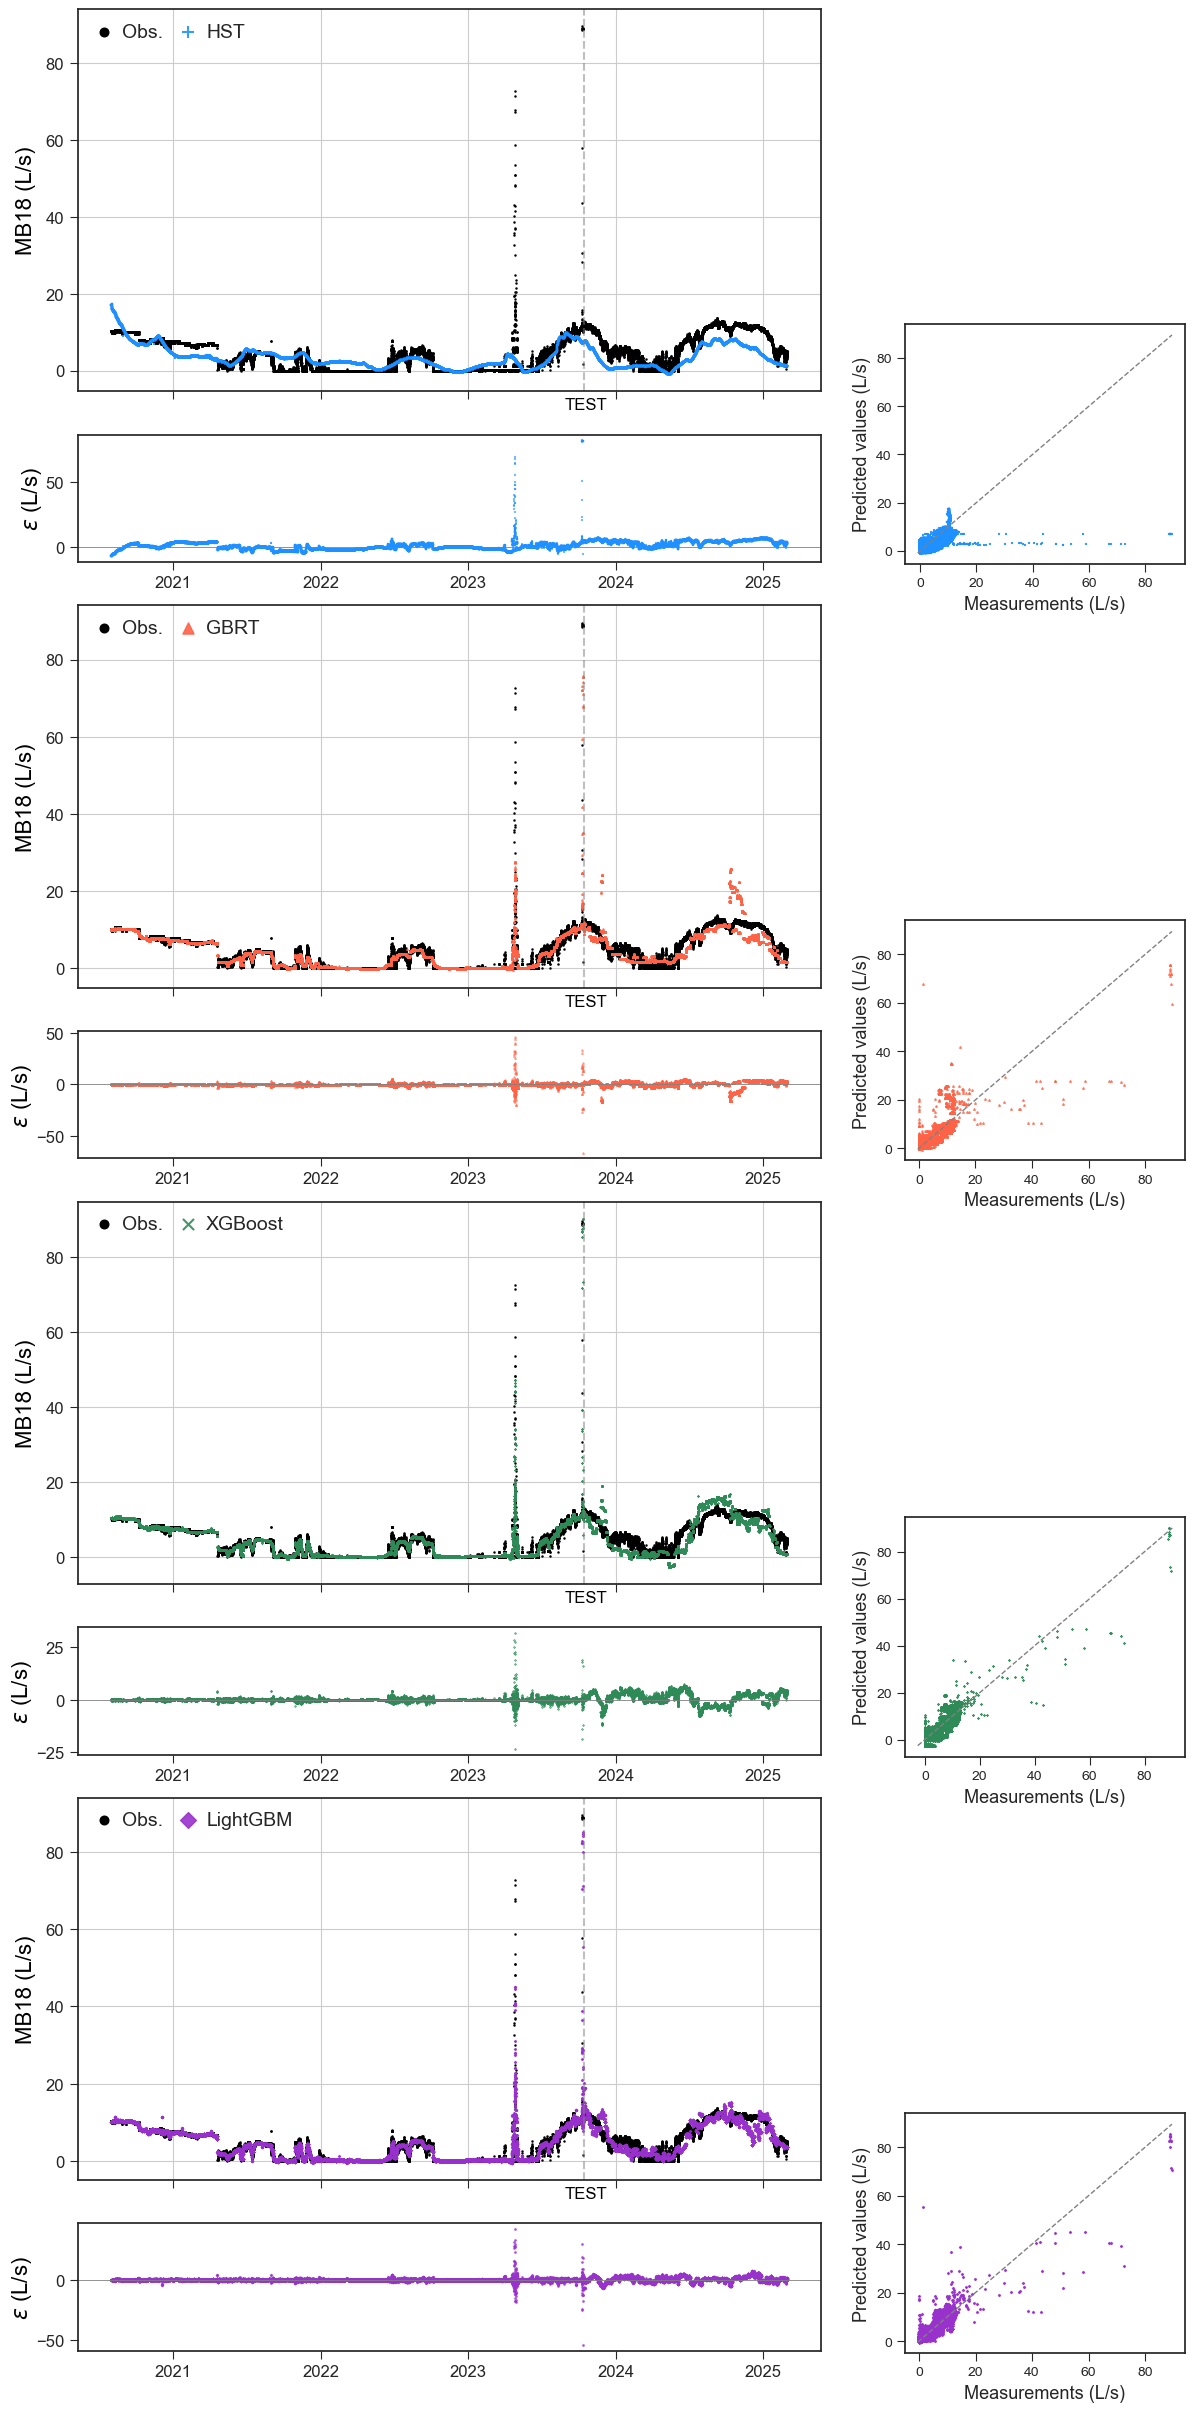

In [134]:
main_plot('MB18', shared_residual_axis=False)